# Analyze inductive inference task data

In [1]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from mindstorm import statplot
from tesser import tasks
from tesser import figures

bids_dir = os.environ['TESSER_BIDS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'plots')
os.makedirs(fig_dir, exist_ok=True)

## Temporal bias for each trial type

In [2]:
induct = tasks.load_induct(bids_dir)
induct = tasks.score_induct(induct)
induct.head()

,onset,duration,trial_type,environment,community,cue,opt1,opt2,within_opt,response,response_time,run,subject,correct
0,0.000,8.000,central,ocean,1,2,16,20,2,NaN,NaN,1,100,NaN
1,8.500,2.974,boundary2,desert,2,4,10,19,1,2.0,2.974,1,100,0.0
2,11.974,3.191,central,desert,2,5,6,2,1,1.0,3.191,1,100,1.0
3,15.665,3.374,central,ocean,1,2,9,19,2,2.0,3.374,1,100,1.0
4,19.539,3.095,central,ocean,1,1,19,13,1,2.0,3.095,1,100,0.0


In [3]:
bias = (induct.groupby(['subject', 'trial_type'])[['correct']].mean() - .5) * 2
bias = bias.reset_index()

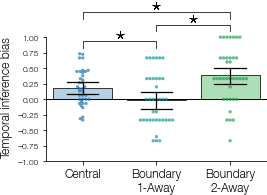

In [4]:
colors = figures.get_induct_colors()
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    bias,
    x='trial_type',
    y='correct',
    dark=colors['dark'],
    light=colors['light'],
    point_kws={'clip_on': False},
    ax=ax,
)
ax.set(
    ylim=(-1, 1), ylabel='Temporal inference bias',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away']
)
x_lim = ax.get_xlim()
ax.hlines(0, *x_lim, color='k')
ax.set_xlim(*x_lim);
x = sorted([p.get_x() + p.get_width() / 2 for p in ax.patches])
y = bias.groupby('trial_type')['correct'].max().to_list()
offset = 0.05 * np.diff(ax.get_ylim())
ax.set(ylim=(-1, 1.6), yticks=np.arange(-1, 1.25, .25))
ax.spines['left'].set_bounds(-1, 1)
statplot.plot_sig([x[0], x[1]], [y[0], y[1]], offset, ax=ax)
statplot.plot_sig([x[1], x[2]], [y[1], y[2]], offset, ax=ax)
statplot.plot_sig([x[0], x[2]], [y[0] + offset * 2, y[2] + offset * 2], offset, ax=ax)
ax.yaxis.set_label_coords(-.15, 0.4)
fig.savefig(os.path.join(fig_dir, 'temporal_bias.pdf'))

### Is there significant temporal bias?

In [5]:
mat = pd.pivot(
    data=bias, index='subject', columns='trial_type', values='correct'
)
stats = pd.concat(
    [pg.ttest(mat[col], 0) for col in mat.columns], axis=0, keys=mat.columns
)
stats['p-cor'] = pg.multicomp(stats['p-val'].to_numpy(), method='fdr_bh')[1]
stats

,,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,p-cor
trial_type,,,,,,,,,,
central,T-test,3.967068,36,two-sided,0.000332,"[0.09, 0.28]",0.652182,83.77,0.971232,0.000498
boundary1,T-test,-0.182485,36,two-sided,0.856226,"[-0.15, 0.13]",0.030000,0.18,0.053624,0.856226
boundary2,T-test,5.287677,36,two-sided,0.000006,"[0.24, 0.53]",0.869289,3159.569,0.999269,0.000019


### Does temporal bias vary by trial type?

In [6]:
pg.rm_anova(data=bias, dv='correct', within='trial_type', subject='subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,trial_type,2,72,14.270354,0.000006,0.283872,0.88351


In [7]:
pg.pairwise_ttests(
    data=bias, dv='correct', within='trial_type', subject='subject'
)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,trial_type,boundary1,boundary2,True,True,-4.735596,36.0,two-sided,0.000034,669.792,-0.909924
1,trial_type,boundary1,central,True,True,-3.297114,36.0,two-sided,0.002204,15.542,-0.546255
2,trial_type,boundary2,central,True,True,2.581411,36.0,two-sided,0.014059,3.14,0.528246


## Relationship between trial types

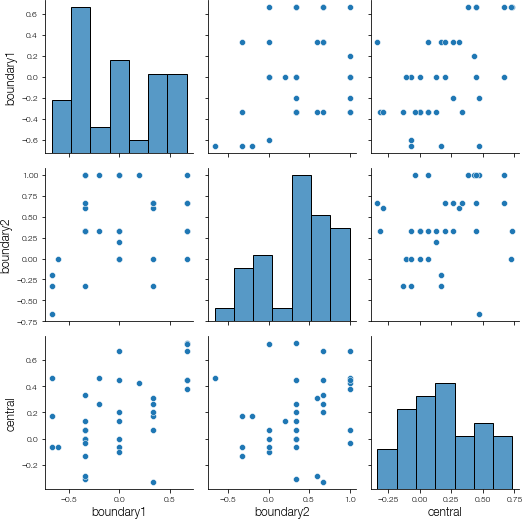

In [8]:
mat = pd.pivot(data=bias, index='subject', columns='trial_type', values='correct')
sns.pairplot(mat);

In [9]:
pg.pairwise_corr(mat, padjust='fdr_bh')

,X,Y,method,tail,n,r,CI95%,p-unc,p-corr,p-adjust,BF10,power
0,boundary1,boundary2,pearson,two-sided,37,0.302836,"[-0.02, 0.57]",0.068470,0.102704,fdr_bh,1.011,0.453870
1,boundary1,central,pearson,two-sided,37,0.518604,"[0.23, 0.72]",0.001008,0.003023,fdr_bh,37.131,0.923338
2,boundary2,central,pearson,two-sided,37,0.229350,"[-0.1, 0.52]",0.172102,0.172102,fdr_bh,0.502,0.280207


## Response time for each trial type

In [10]:
exclude = (
    induct.groupby(['correct', 'trial_type', 'subject'])['response_time']
    .count()
    .unstack(['correct', 'trial_type']) == 0
).any(1)
exclude_subjects = exclude.index[exclude.to_numpy()].to_numpy()
induct_include = induct.loc[~induct['subject'].isin(exclude_subjects)]
exclude.sum()

7

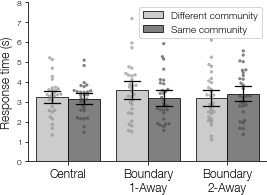

In [11]:
rt = induct_include.groupby(['trial_type', 'correct', 'subject'])['response_time'].mean()
rt = rt.reset_index()
dark = [(.6, .6, .6), (.3, .3, .3)]
light = [(.8, .8, .8), (.5, .5, .5)]
rt['Response'] = rt['correct'].map({0: 'Different community', 1: 'Same community'})
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    rt,
    x='trial_type',
    y='response_time',
    hue='Response',
    dark=dark,
    light=light,
    dodge=True,
    bar_kws={'capsize': .2},
    ax=ax,
)
ax.set(
    ylim=(0, 8),
    ylabel='Response time (s)',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away']
);
fig.savefig(os.path.join(fig_dir, 'temporal_bias_rt.pdf'))

In [12]:
pg.rm_anova(
    data=rt,
    dv='response_time',
    subject='subject',
    within=['trial_type', 'Response']
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,trial_type,0.912830,2,58,0.456415,1.038655,0.360419,0.346931,0.034577,0.788474
1,Response,0.424505,1,29,0.424505,1.583853,0.218245,0.218245,0.051787,1.000000
2,trial_type * Response,2.948296,2,58,1.474148,4.286965,0.018348,0.022853,0.128788,0.884433


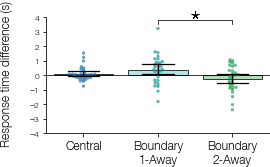

In [13]:
mrt = induct_include.groupby(['correct', 'trial_type', 'subject'])['response_time'].mean()
diff = (mrt.loc[0] - mrt.loc[1]).reset_index()

fig, ax = plt.subplots(figsize=(4.75 * .85, 3 * .85))
statplot.plot_swarm_bar(
    diff,
    x='trial_type',
    y='response_time',
    dark=colors['dark'],
    light=colors['light'],
    ax=ax,
);
ax.axline((0, 0), slope=0, color='k', linewidth=.75);
x = sorted([p.get_x() + p.get_width() / 2 for p in ax.patches])
y = diff.groupby('trial_type')['response_time'].max().to_list()
offset = 0.05 * np.diff(ax.get_ylim())
ax.set(ylim=(-4, 4.5), yticks=np.arange(-4, 4.25, 1))
ax.spines['left'].set_bounds(-4, 4)
statplot.plot_sig([x[1], x[2]], [y[1], y[2]], offset, ax=ax)
ax.yaxis.set_label_coords(-.15, .49)
ax.set(
    ylabel='Response time difference (s)',
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
);
fig.savefig(os.path.join(fig_dir, 'temporal_bias_rt_diff.pdf'))

### Does response time difference vary by trial type?

In [14]:
pg.pairwise_ttests(
    data=diff,
    dv='response_time',
    subject='subject',
    within='trial_type',
    effsize='cohen',
)

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,trial_type,central,boundary1,True,True,-1.513264,29.0,two-sided,0.141036,0.541,-0.381813
1,trial_type,central,boundary2,True,True,1.717295,29.0,two-sided,0.096588,0.717,0.478555
2,trial_type,boundary1,boundary2,True,True,2.507658,29.0,two-sided,0.018004,2.749,0.683838


In [15]:
mat = pd.pivot(
    data=diff, index='subject', columns='trial_type', values='response_time'
)
stats = pd.concat(
    [pg.ttest(mat[col], 0) for col in mat.columns], axis=0, keys=mat.columns
)
stats['p-cor'] = pg.multicomp(stats['p-val'].to_numpy(), method='fdr_bh')[1]
stats

,,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,p-cor
trial_type,,,,,,,,,,
central,T-test,1.269802,29,two-sided,0.214250,"[-0.07, 0.29]",0.231833,0.403,0.232804,0.21425
boundary1,T-test,2.289917,29,two-sided,0.029490,"[0.04, 0.76]",0.418080,1.831,0.600151,0.08847
boundary2,T-test,-1.414035,29,two-sided,0.167998,"[-0.55, 0.1]",0.258166,0.477,0.277171,0.21425


In [16]:
%load_ext watermark
%watermark -i -m -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

matplotlib: 3.4.2
tesser    : 0.1.0
pandas    : 1.2.5
seaborn   : 0.11.1
numpy     : 1.18.1
pingouin  : 0.3.12
mindstorm : 0.8.1

